## Set-up

In [ ]:
# Environment setup
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip3 install tensorflow-addons
import tensorflow_addons as tfa
autotune = tf.data.AUTOTUNE
!pip3 install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-d7jtlicj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-d7jtlicj
  Resolved https://github.com/tensorflow/examples.git to commit 0cc44f2e65499120bd2fdacf6f5be7eab7b416ef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0cc44f2e65499120bd2fdacf6f5be7eab7b416ef_-py3-none-any.whl size=299716 sha256=aa4886ddf033c11c703d459681c7d0b93c3dc19738f04c2511204dc0eadf3ab0
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9c047o0/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Failed to build tensorflow-e

In [ ]:
# Load the data from GoogleDrive (this will need to be updated with your own GoogleDrive link)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load and Preprocess

In [ ]:
# Create a directory of the images
faces_dir = '/content/gdrive/MyDrive/Colab Notebooks/CSC8637/Faces/Faces'
catdog_dir = '/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CatDogFaces/'

In [ ]:
# Create face train and test subsets
train_faces = tf.keras.utils.image_dataset_from_directory(
    faces_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (256, 256),
    batch_size =1)

test_faces = tf.keras.utils.image_dataset_from_directory(
    faces_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    shuffle = True,
    image_size = (256, 256),
    batch_size = 1)

# Get input size
train_input_shape = None
test_input_shape = None

for image_batch, label_batch in train_faces:
    train_input_shape = image_batch.shape
    break

for image_batch, label_batch in test_faces:
    test_input_shape = image_batch.shape
    break

print("Training set input size:", train_input_shape)
print("Test set input size:", test_input_shape)

Found 757 files belonging to 2 classes.
Using 606 files for training.
Found 757 files belonging to 2 classes.
Using 151 files for validation.
Training set input size: (1, 256, 256, 3)
Test set input size: (1, 256, 256, 3)


In [ ]:
# Create catdog train and test subsets
train_catdog = tf.keras.utils.image_dataset_from_directory(
    catdog_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (256, 256),
    batch_size = 1)

test_catdog = tf.keras.utils.image_dataset_from_directory(
    catdog_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    shuffle = True,
    image_size = (256, 256),
    batch_size = 1)

# Get input size
train_input_shape = None
test_input_shape = None

for image_batch, label_batch in train_catdog:
    train_input_shape = image_batch.shape
    break

for image_batch, label_batch in test_catdog:
    test_input_shape = image_batch.shape
    break

print("Training set input size:", train_input_shape)
print("Test set input size:", test_input_shape)

Found 48863 files belonging to 2 classes.
Using 39091 files for training.
Found 48863 files belonging to 2 classes.
Using 9772 files for validation.
Training set input size: (1, 256, 256, 3)
Test set input size: (1, 256, 256, 3)


In [ ]:
# Normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
# Set up random jitter
def random_jitter(batch, resize_dim=286, crop_dim=256):
    # Resize to slightly larger dimensions
    batch = tf.image.resize(batch, [resize_dim, resize_dim],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random crop back to original size
    batch = tf.image.random_crop(batch, [tf.shape(batch)[0], crop_dim, crop_dim, 3])

    # Random flip
    batch = tf.image.random_flip_left_right(batch)

    return batch

In [ ]:
# Function for train preprocessing
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

# Function for test preprocessing
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
# Map pre-rpocessing to train and test sets
BUFFER_SIZE = 1000
BATCH_SIZE = 1

train_faces = train_faces.cache().map(
    preprocess_image_train, num_parallel_calls=autotune).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_catdog = train_catdog.cache().map(
    preprocess_image_train, num_parallel_calls=autotune).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_faces = test_faces.map(
    preprocess_image_test, num_parallel_calls=autotune).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_catdog = test_catdog.map(
    preprocess_image_test, num_parallel_calls=autotune).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Create samples
sample_faces = next(iter(train_faces))
sample_catdog = next(iter(train_catdog))

In [ ]:
# Confirm sample shape
print(sample_faces.shape)  # prints (batch_size, height, width, channels)
print(sample_catdog.shape)  # prints (batch_size, height, width, channels)


(1, 1, 256, 256, 3)
(1, 1, 256, 256, 3)


In [ ]:
# Remove extra dimension from sample
sample_faces = tf.squeeze(sample_faces, axis=0)
sample_catdog = tf.squeeze(sample_catdog, axis=0)

In [ ]:
# Confirm sample shape
print(sample_faces.shape)  # prints (batch_size, height, width, channels)
print(sample_catdog.shape)  # prints (batch_size, height, width, channels)

(1, 256, 256, 3)
(1, 256, 256, 3)


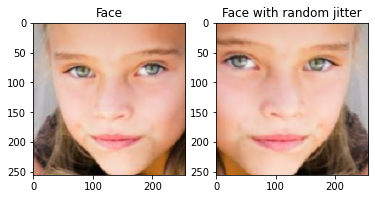

In [ ]:
# See training example of face
plt.subplot(121)
plt.title('Face')
plt.imshow(sample_faces[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Face with random jitter')
jittered_faces = random_jitter(sample_faces)
plt.imshow(jittered_faces[0] * 0.5 + 0.5)


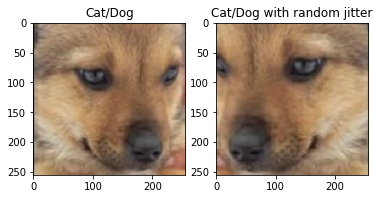

In [ ]:
# See training example of cat/dog
plt.subplot(121)
plt.title('Cat/Dog')
plt.imshow(sample_catdog[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Cat/Dog with random jitter')
jittered_catdog = random_jitter(sample_catdog)
plt.imshow(jittered_catdog[0] * 0.5 + 0.5)

## Modelling

In [ ]:
#Import and reuse the Pix2Pix model
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

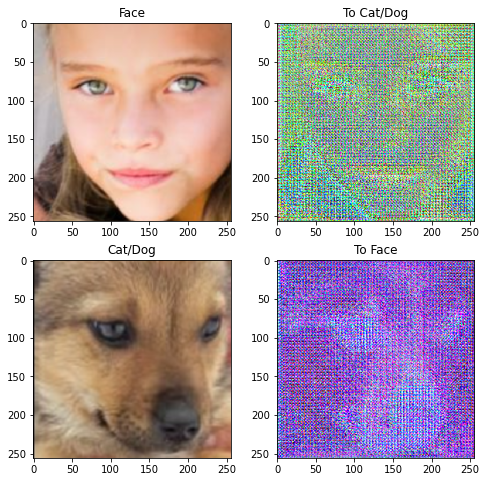

In [ ]:
# Apply Pix2Pix generator to sample face and cat/dog
to_catdog = generator_g(sample_faces)
to_faces = generator_f(sample_catdog)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_faces, to_catdog, sample_catdog, to_faces]
title = ['Face', 'To Cat/Dog', 'Cat/Dog', 'To Face']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

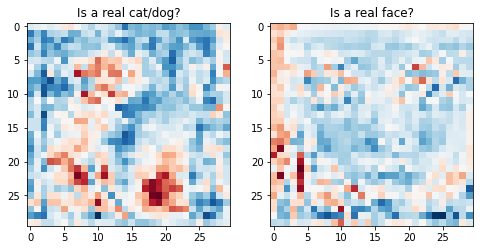

In [ ]:
# Apply Pix2Pix discriminator to sample face and cat/dog
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real cat/dog?')
plt.imshow(discriminator_y(sample_catdog)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real face?')
plt.imshow(discriminator_x(sample_faces)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss Functions

In [ ]:
LAMBDA = 10 # tried lambda 1 and 15, results didn't improve

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

## Optimizers

In [ ]:
# Initialize AdamW for all the generators and the discriminators.
generator_g_optimizer = tf.keras.optimizers.experimental.AdamW(2e-4, beta_1=0.5) #tried Adam and AdamW / it's learning rate - tried 1e-4, 2e-2 and 3e-4 instead, didn't improve / beta - tried 1, awful, same with 0.2
generator_f_optimizer = tf.keras.optimizers.experimental.AdamW(2e-4, beta_1=0.5)


discriminator_x_optimizer = tf.keras.optimizers.experimental.AdamW(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.experimental.AdamW(2e-4, beta_1=0.5)

In [ ]:
# Initialize Adam for all the generators and the discriminators.
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) #tried Adam and AdamW / it's learning rate - tried 1e-4, 2e-2 and 3e-4 instead, didn't improve / beta - tried 1, awful, same with 0.2
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/CSC8637/checkpoints/final_extra_adam2e-4,beta1_0.5,lambda10'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Modelling

In [ ]:
#Set up number of epochs
EPOCHS = 20

# Increased from 10 after it worked.


In [ ]:
# Function for generating images from the model
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# Training function
@tf.function
def train_step(real_x, real_y):

  real_x = tf.squeeze(real_x, axis=0)
  real_y = tf.squeeze(real_y, axis=0)
  real_x = tf.image.resize(real_x, [256, 256])
  real_y = tf.image.resize(real_y, [256, 256])

  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

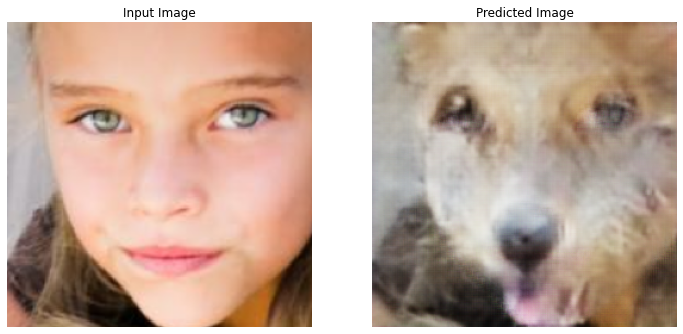

Saving checkpoint for epoch 20 at /content/gdrive/MyDrive/Colab Notebooks/CSC8637/checkpoints/final_extra_adam2e-4,beta1_0.5,lambda10/ckpt-4
Time taken for epoch 20 is 46.639594316482544 sec



In [ ]:
# Train the model
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_faces, train_catdog)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_faces) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_faces)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# Save the trained model
generator_g.save('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/models/cycleGAN_g_Adam_extra.h5')

## Evaluation (Tests)

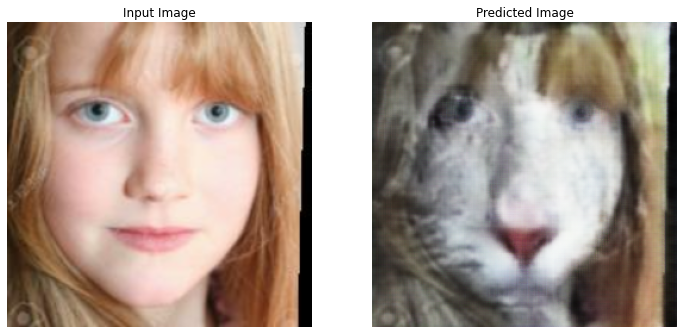

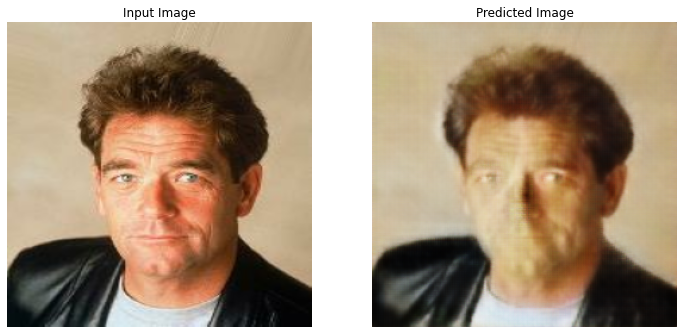

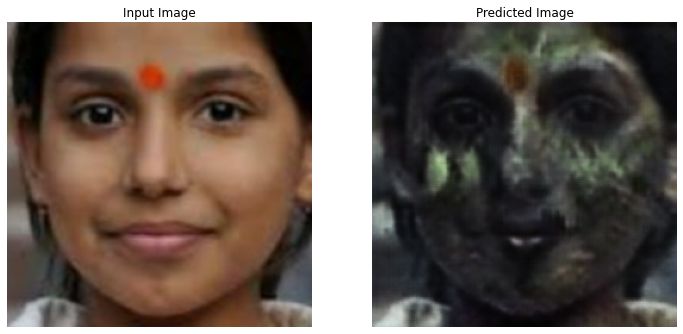

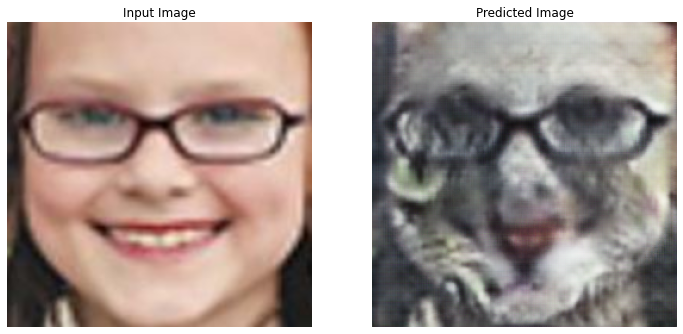

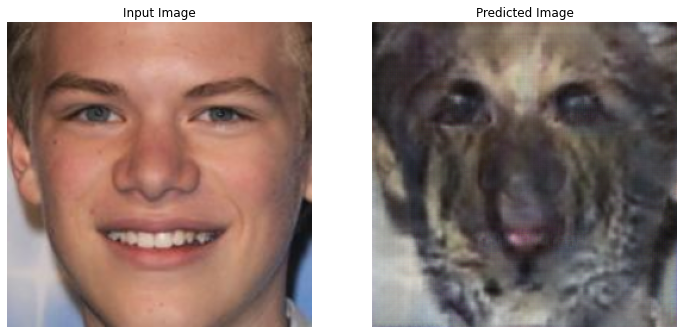

In [ ]:
# Run the trained model on the test dataset
for inp in test_faces.take(5):
    inp = tf.squeeze(inp, axis=0)
    inp = tf.image.resize(inp, [256, 256])
    generate_images(generator_g, inp)

In [ ]:
# Load in my face
myface = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/MyFace/Me.jpg')

In [ ]:
# Load in staff
steve = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/Staff/StephenMcGough.jpg')
tong = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/Staff/TongXin.jpg')
amir = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/Staff/AmirAbarghouei.jpg')
david = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/Staff/DavidTowers.jpg')

In [ ]:
# Normalise and resize myface
myface = tf.image.resize(myface, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
myface = normalize(myface)

In [ ]:
# Normalise and resize staff images
steve = tf.image.resize(steve, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
steve = normalize(steve)
tong = tf.image.resize(tong, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
tong = normalize(tong)
amir = tf.image.resize(amir, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
amir = normalize(amir)
david = tf.image.resize(david, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
david = normalize(david)

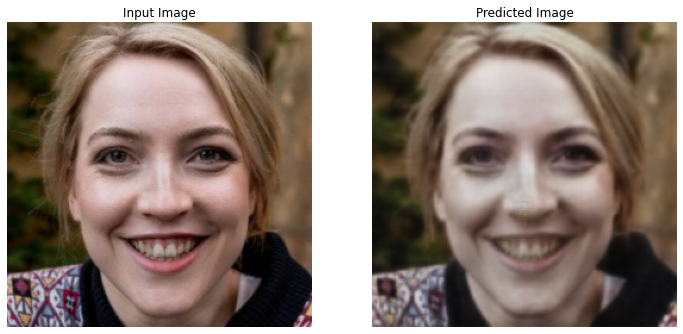

In [ ]:
# Reshape the input image to have a batch dimension
myface_batch = np.expand_dims(myface, axis=0)

# Generate the myface predicted image using the trained model
generate_images(generator_g, myface_batch)

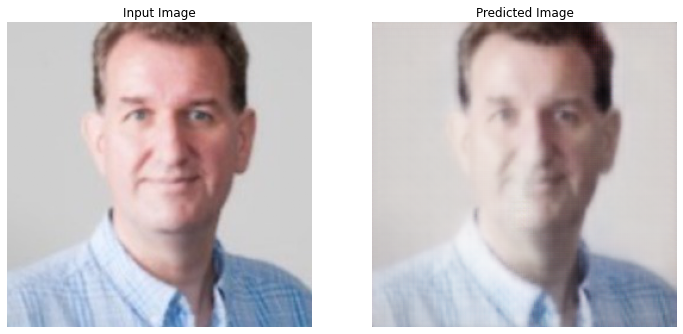

In [ ]:
# Reshape the input image to have a batch dimension
steve_batch = np.expand_dims(steve, axis=0)

# Generate the steve predicted image using the trained model
generate_images(generator_g, steve_batch)

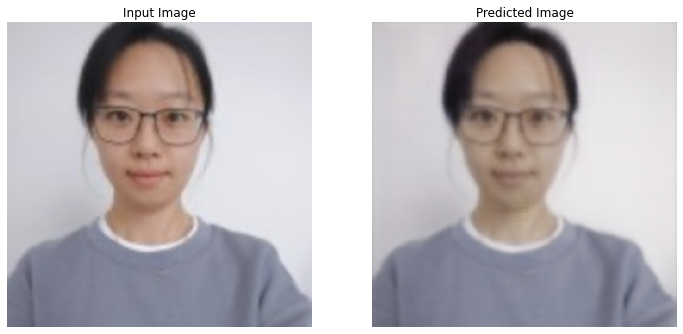

In [ ]:
# Reshape the input image to have a batch dimension
tong_batch = np.expand_dims(tong, axis=0)

# Generate the tong predicted image using the trained model
generate_images(generator_g, tong_batch)

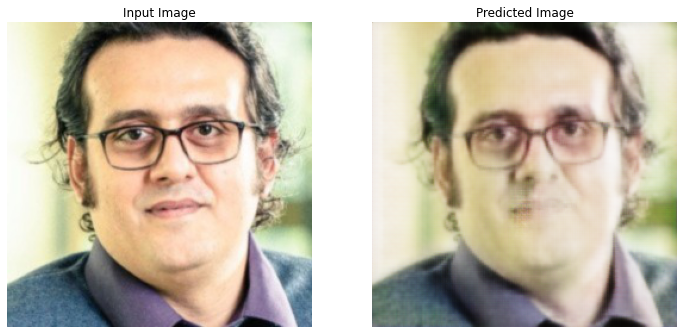

In [ ]:
# Reshape the input image to have a batch dimension
amir_batch = np.expand_dims(amir, axis=0)

# Generate the amir predicted image using the trained model
generate_images(generator_g, amir_batch)

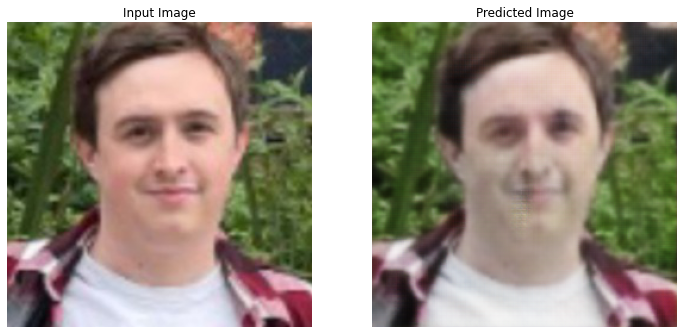

In [ ]:
# Reshape the input image to have a batch dimension
david_batch = np.expand_dims(david, axis=0)

# Generate the david predicted image using the trained model
generate_images(generator_g, david_batch)

## New Images

In [ ]:
# Load pre-existing Model
import tensorflow as tf

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset


# Load the saved model
generator_g = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/models/cycleGAN_g_Adam_extra.h5',
                                         custom_objects={'InstanceNormalization': InstanceNormalization}, compile=False)


In [ ]:
# Load in image
image = tf.keras.utils.load_img('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CSC8637 testing/Task1_Tong.jpg')

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
# Generate image function
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# Normalise and resize image
image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image = normalize(image)

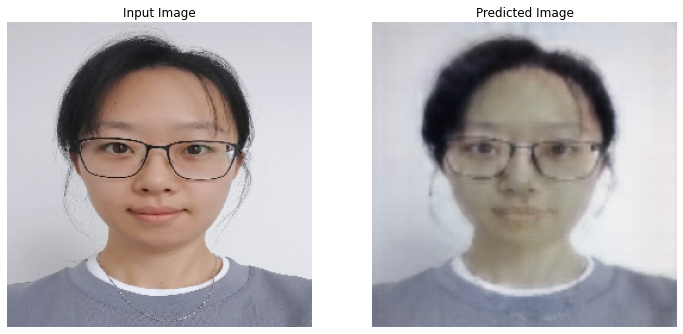

In [ ]:
# Reshape the input image to have a batch dimension
image_batch = np.expand_dims(image, axis=0)

# Generate the image predicted image using the trained model
generate_images(generator_g, image_batch)